In [2]:
# Import necessary libraries 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import spacy
import string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D,Dense,Embedding,MaxPooling1D,GlobalMaxPooling1D,Input
from keras.models import Model,Sequential
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud
import tensorflow as tf

In [3]:
nltk.download("stopwords") #download nltk 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ahame\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Import the dataset as csv using pandas and remove unwanted columns
dataset= pd.read_csv("./data/sms_spam_ham.csv",encoding='latin-1') 
dataset.drop(columns=[
    'Unnamed: 2',
    'Unnamed: 3',
    'Unnamed: 4',
] , inplace=True)
dataset.head(20)

,label,review
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
dataset.describe()

,label,review
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   review  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
dataset.groupby('label').describe()

review                                                               
       count unique                                                top freq
label                                                                      
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [9]:
dataset['length'] = dataset['review'].apply(len) # add a length column for get the length of each review texts

In [10]:
dataset.head()

,label,review,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [11]:
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [12]:
label_encoder = LabelEncoder()

In [13]:
dataset['label'] = label_encoder.fit_transform(dataset['label']) # add Label encoding to target column 

In [14]:
dataset['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int32

In [15]:
## Correlation
dataset.corr()

,label,length
label,1.000000,0.387285
length,0.387285,1.000000


## Data Visualization

<Axes: ylabel='Frequency'>

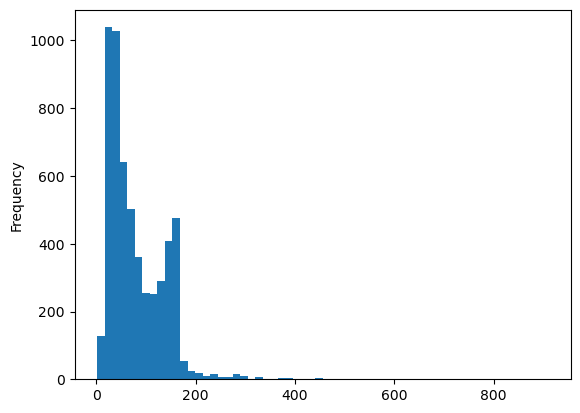

In [16]:
dataset['length'].plot.hist(bins=60)

In [17]:
dataset['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

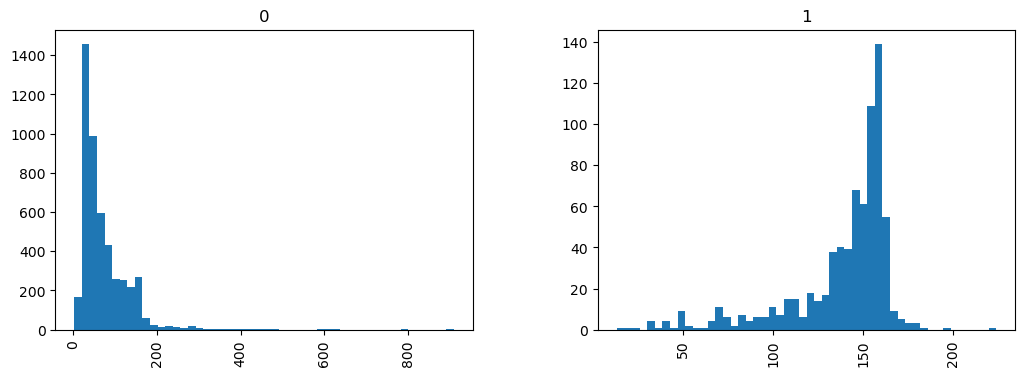

In [18]:
dataset.hist(column='length',by='label',bins=50,figsize=(12,4))

<Axes: xlabel='label', ylabel='length'>

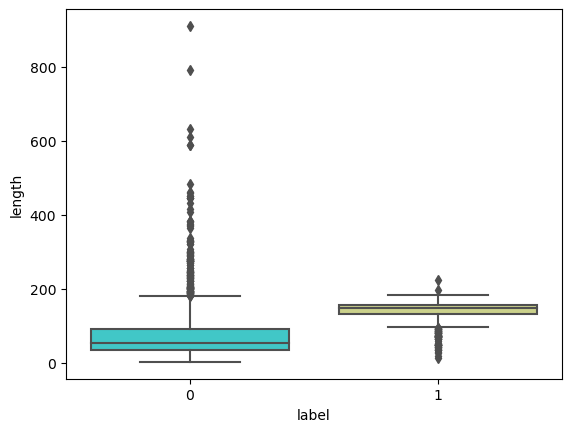

In [19]:
sns.boxplot(x='label',y='length',data=dataset,palette='rainbow')

<Axes: xlabel='label', ylabel='count'>

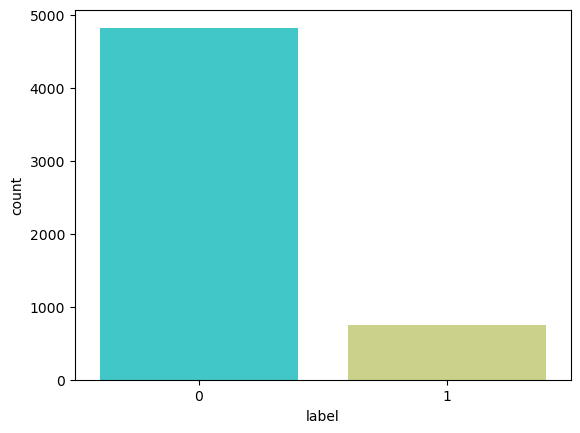

In [20]:
sns.countplot(x='label',data=dataset,palette='rainbow')

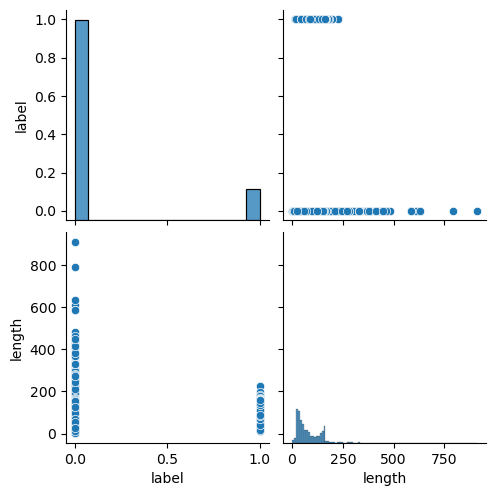

In [21]:
sns.pairplot(dataset)

## Data Cleaning

In [22]:
# Checking for NaN values
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [23]:
# Checking for empty whitespace strings and assign for an array 
empty_list = []  

for i,label,review,length in dataset.itertuples():  # iterate over the DataFrame
    if type(review)==str:           
        if review.isspace():         
            empty_list.append(i)    
        
len(empty_list)

0

In [24]:
#droping NaN values
dataset.dropna(inplace=True)

In [25]:
#drop empty space values in review 
dataset.drop(empty_list,inplace=True)

In [26]:
# Checking for duplicate values
dataset.duplicated().sum()

403

In [27]:
#remove duplicate entries
dataset.drop_duplicates(keep='first',inplace=True)

In [28]:
#identify the important punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
#load english vocabulary
nlp_load = spacy.load("en_core_web_sm")


In [30]:
nlp_load.max_length = 200000

In [31]:
#Create a function to identify the punctuations in each words
def separate_puncuation(doc_text):
    return [token for token in nlp_load(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']


In [32]:
#check wheter there are any single puncuations and convert the row to string
def remove_punctuation_and_convert_to_string(token):
    return ''.join(char for char in str(token) if char not in string.punctuation)

In [33]:
#remove stopwords from each row
def remove_stop(token):
    return [word for word in token.split() if word.lower() not in stopwords.words('english')]

In [34]:
lemmatize = WordNetLemmatizer()
# lemmatize word
def lemmatize_word(doc_text):
    lemmatized_word = [lemmatize.lemmatize(word, pos ='v') for word in doc_text]
    return lemmatized_word

In [35]:
#convert each tokens to string after removing stopwords
def join_list_to_string(lst):
    return ' '.join(lst)

In [36]:
dataset['review'] = dataset['review'].apply(separate_puncuation)

In [37]:
dataset['review'] = dataset['review'].apply(remove_punctuation_and_convert_to_string)

In [38]:
dataset['review'] = dataset['review'].apply(remove_stop)

In [39]:
dataset['review'] = dataset['review'].apply(lemmatize_word)

In [40]:
dataset['review'] = dataset['review'].apply(lambda x: join_list_to_string(x))

In [41]:
dataset['review'] 

0       Go jurong point crazy Available bugis n great ...
1                                 Ok lar Joking wif u oni
2       Free entry 2 wkly comp win FA Cup final tkts 2...
3                     U dun say early hor U c already say
4                  Nah nt think go usf live around though
                              ...                        
5567    2nd time try 2 contact u U å£750 Pound prize 2...
5568                             Ì b go esplanade fr home
5569                                Pity mood suggestions
5570    guy bitch act like interest buy something else...
5571                                       Rofl true name
Name: review, Length: 5169, dtype: object

In [42]:
#get the values of target data from dataset
target = dataset['label'].values

In [43]:
#get the values of taining data from dataset
train =dataset['review'].values

In [44]:
target.shape

(5169,)

In [45]:
# remove all puctuations (train data)
# remove all stopwords
# create a key value pair for word and vector an store 

token_response = []
word2vec={}
for text in train:
    tokens = separate_puncuation(text)
    for x in tokens:
        #word=x.text
        rem_punc = [single_letter for single_letter in x.text if single_letter not in string.punctuation]
        word=''.join(rem_punc)
        if word.lower() not in stopwords.words('english') :
            vec=np.asarray(x.vector,dtype='float32')
            word2vec[word]=vec
            #print(word)
    token_response.append(tokens)
  


In [46]:
#display allwords after removing stopwords
word_list = list(word2vec.keys())

## Tokenization

In [47]:
#initialize constans
sequece_length = 96
vocabulary_size = 20000
embedding_dim = 96
validation_split = 0.2
batch_size = 128
epochs = 10

In [48]:
#convert the sentence to integer
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train)
sequences = tokenizer.texts_to_sequences(train)

In [49]:
#word integer mapping
word_index = tokenizer.word_index

In [50]:
#pad sequences to create NxT matrix
ps_data = pad_sequences(sequences , maxlen=sequece_length)

In [51]:
ps_data.shape

(5169, 96)

## Create ANN Model

In [52]:
#create ann model
ann = Sequential()
ann.add(Dense(64, activation='relu', input_shape=(96,)))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(16, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

In [53]:
ann.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

In [54]:
#model summary
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8833 (34.50 KB)
Trainable params: 8833 (34.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model_history = ann.fit(ps_data,target,batch_size=batch_size,epochs=epochs,validation_split=validation_split)

Epoch 1/10
33/33 [==============================] - 1s 9ms/step - loss: 14.5880 - accuracy: 0.7879 - val_loss: 4.3832 - val_accuracy: 0.7631
Epoch 2/10
33/33 [==============================] - 0s 3ms/step - loss: 2.3373 - accuracy: 0.8380 - val_loss: 2.1438 - val_accuracy: 0.8530
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 0.9860 - accuracy: 0.8663 - val_loss: 1.4445 - val_accuracy: 0.8598
Epoch 4/10
33/33 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.8774 - val_loss: 1.1054 - val_accuracy: 0.8926
Epoch 5/10
33/33 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.8735 - val_loss: 0.8751 - val_accuracy: 0.8897
Epoch 6/10
33/33 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.8900 - val_loss: 0.8426 - val_accuracy: 0.8733
Epoch 7/10
33/33 [==============================] - 0s 4ms/step - loss: 0.4543 - accuracy: 0.8907 - val_loss: 0.9364 - val_accuracy: 0.8975
Epoch 8/10
33/33 [=

### Loss

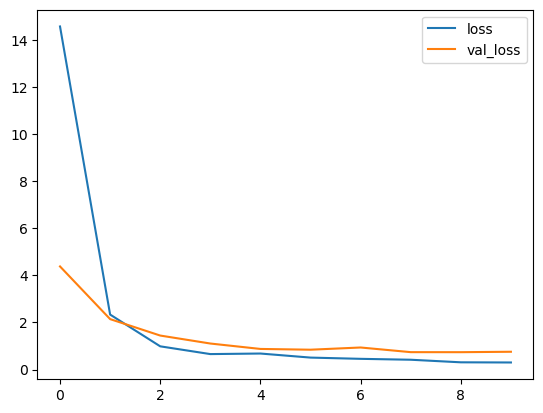

In [56]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

### Accuracy

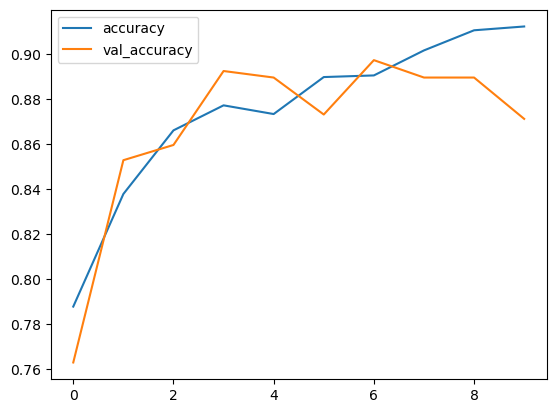

In [57]:
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [58]:
prediction=ann.predict(ps_data)

162/162 [==============================] - 2s 3ms/step


In [59]:
threshold_value = 0.5

In [60]:
prediction_summary = (prediction > threshold_value).astype(int)

In [61]:
concatenated_array = np.concatenate((target.reshape(len(target), 1), prediction_summary.reshape(len(prediction_summary), 1)), 1)

In [62]:
np.set_printoptions(threshold=np.inf)

In [63]:
concatenated_array

array([[0, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0,

In [64]:
common_words = FreqDist(word_list).most_common(50)

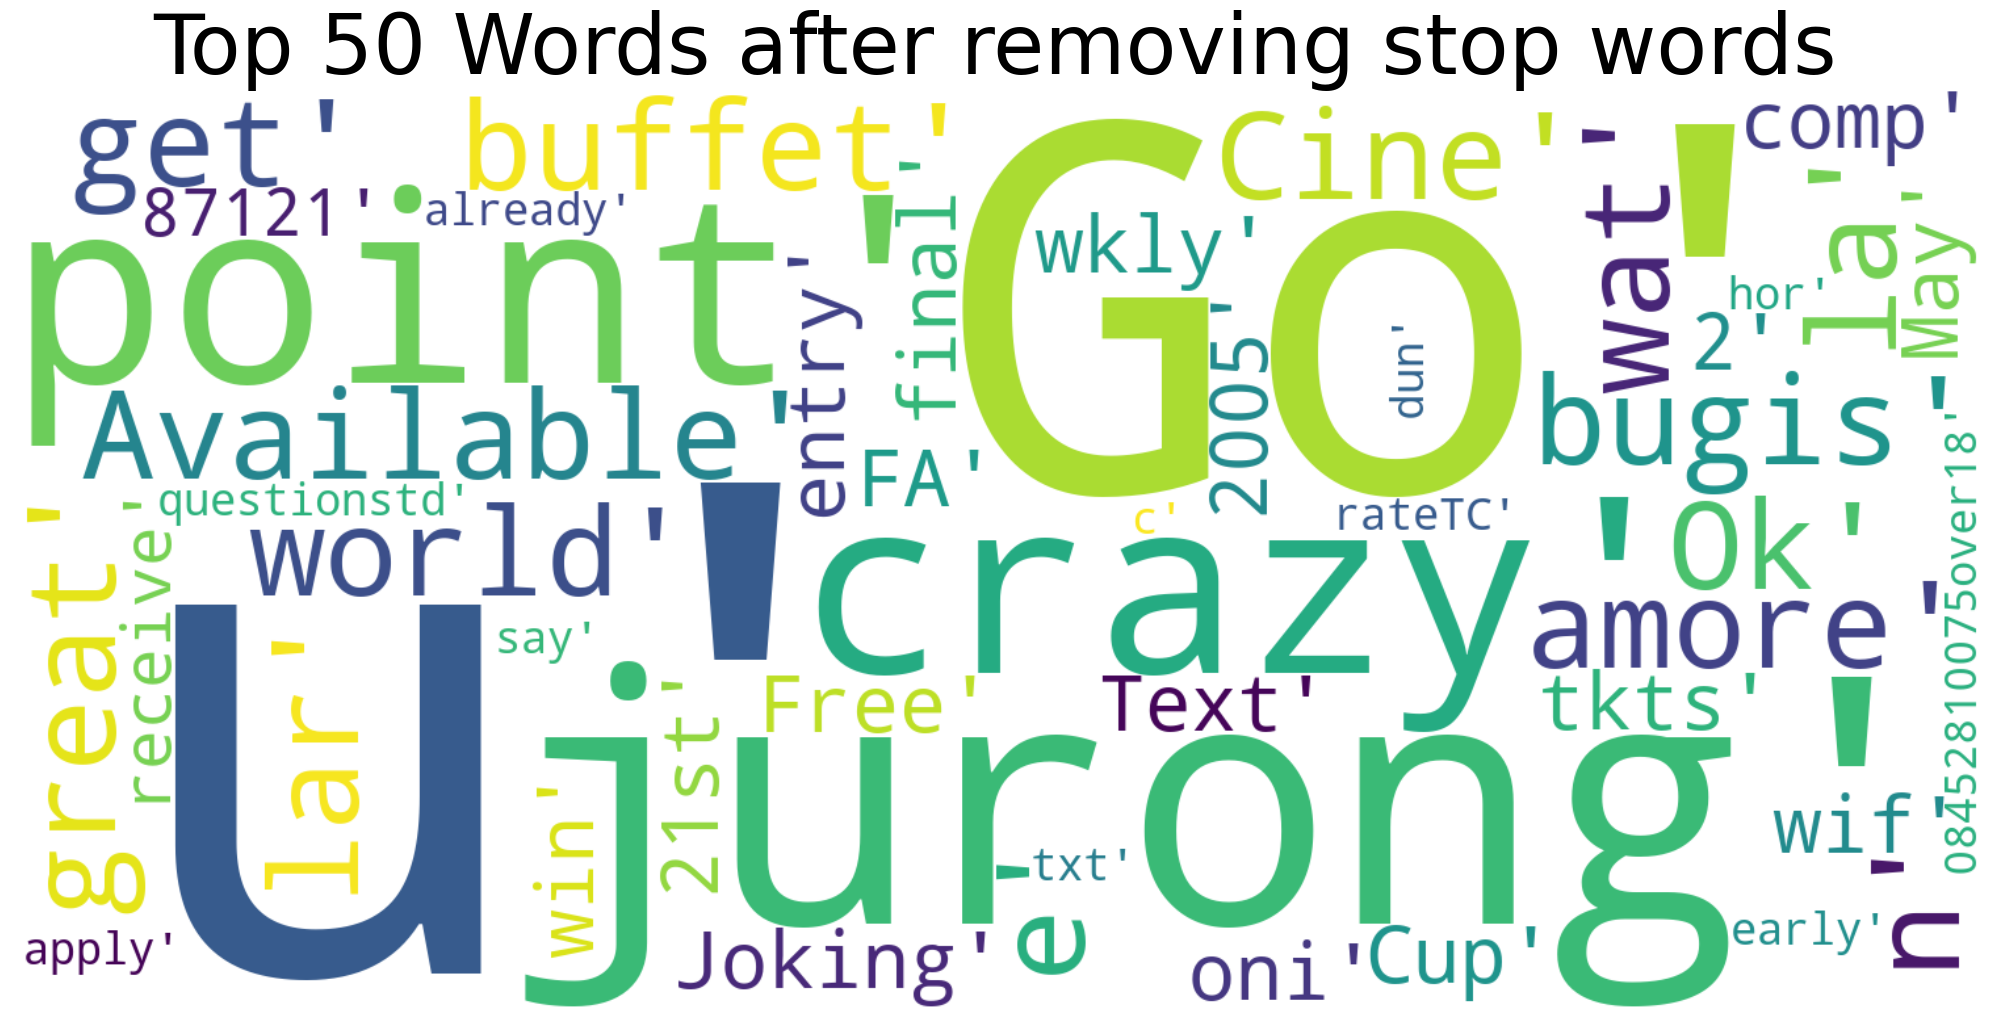

In [65]:

wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(str(common_words))
fig = plt.figure(figsize=(40,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words after removing stop words', fontsize=60)
plt.tight_layout(pad=0)
plt.show()


## Performance Metrics

In [66]:
from keras.metrics import Precision, Recall ,Accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score

In [67]:
#AUC Score
roc =roc_auc_score(target,prediction)
print("ROC_AUC_SCORE:", roc)

ROC_AUC_SCORE: 0.8804158296450124


In [68]:
#Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(target, prediction_summary))
print("RMSE:", rmse)

RMSE: 0.29928657028188393


In [69]:
#Mean Squared Error
mse = mean_squared_error(target, prediction_summary)
print("MSE:", mse)

MSE: 0.08957245115109305


In [70]:
# Create Precision and Recall metrics
precision = Precision()
recall = Recall()
accuracy = Accuracy()

precision.update_state(target, prediction_summary)
recall.update_state(target, prediction_summary)
accuracy .update_state(target, prediction_summary)


precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()


In [71]:
# display precision and recall values
print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")

Precision: 0.627345860004425
Recall: 0.7166922092437744
Accuracy: 0.9104275703430176


In [72]:
print(classification_report(target, prediction_summary))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4516
           1       0.63      0.72      0.67       653

    accuracy                           0.91      5169
   macro avg       0.79      0.83      0.81      5169
weighted avg       0.92      0.91      0.91      5169



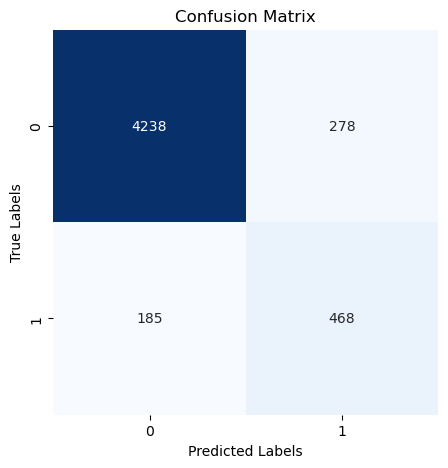

In [73]:
cm = confusion_matrix(target, prediction_summary)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()